In [1]:
# Initialize OK
from client.api.notebook import Notebook
ok = Notebook('lab07.ok')

Assignment: Resampling and the Bootstrap
OK, version v1.12.5



## Lab 7: Resampling and the Bootstrap

The British Royal Air Force wanted to know how many warplanes the Germans had (some number `N`, which is a *parameter*), and they needed to estimate that quantity knowing only a random sample of the planes' serial numbers (from 1 to `N`). We know that the German's warplanes are labeled consecutively from 1 to `N`, so `N` would be the total number of warplanes they have. 

We normally investigate the random variation among our estimates by simulating a sampling procedure from the population many times and computing estimates from each sample that we generate.  In real life, if the RAF had known what the population looked like, they would have known `N` and would not have had any reason to think about random sampling. However, they didn't know what the population looked like, so they couldn't have run the simulations that we normally do.  

Simulating a sampling procedure many times was a useful exercise in *understanding random variation* for an estimate, but it's not as useful as a tool for practical data analysis.

Let's flip that sampling idea on its head to make it practical. Given *just* a random sample of serial numbers, we'll estimate `N`, and then we'll use simulation to find out how accurate our estimate probably is, without ever looking at the whole population.  This is an example of *statistical inference*.

As usual, **run the cell below** to prepare the lab and the automatic tests.

In [4]:
# Run this cell to set up the notebook, but please don't change it.

# These lines import the Numpy and Datascience modules.
import numpy as np
from datascience import *

# These lines do some fancy plotting magic.
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

# These lines load the tests.
from client.api.notebook import Notebook
ok = Notebook('lab07.ok')
_ = ok.submit()

Assignment: Resampling and the Bootstrap
OK, version v1.12.5



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'lab07.ipynb'.
Performing authentication
Please enter your bCourses email.
bCourses email: mingxiuhui@berkeley.edu

Copy the following URL and open it in a web browser. To copy,
highlight the URL, right-click, and select "Copy".

https://okpy.org/client/login/

After logging in, copy the code from the web page, paste it below,
and press Enter. To paste, right-click and select "Paste".

Paste your code here: vMwHPO20rS8Lm3LSU9PkLGktk3R4T4
Successfully logged in as mingxiuhui@berkeley.edu
Submit... 100% complete
Submission successful for user: mingxiuhui@berkeley.edu
URL: https://okpy.org/cal/data8/sp19/lab07/submissions/oV8W3Y



## 1. Preliminaries
We (the RAF in World War II) want to know the number of warplanes fielded by the Germans.  That number is `N`.  The warplanes have serial numbers from 1 to `N`, so `N` is also equal to the largest serial number on any of the warplanes.

We only see a small number of serial numbers (assumed to be a random sample with replacement from among all the serial numbers), so we have to use estimation.

#### Question 1.1
Is `N` a population parameter or a statistic?  If we use our random sample to compute a number that is an estimate of `N`, is that a population parameter or a statistic?

<!--
BEGIN QUESTION
name: q1_1
-->

N is a population parameter. Our estimation of N using the computer program will be a statistic. 

Check your answer with a neighbor or a TA.

To make the situation realistic, we're going to hide the true number of warplanes from you.  You'll have access only to this random sample:

In [11]:
observations = Table.read_table("serial_numbers.csv")
num_observations = observations.num_rows
observations

serial number
47
42
57
79
26
23
36
64
83
135


#### Question 1.2
The average of the sample is about half of `N`. So one way to estimate `N` is to take twice the mean of the serial numbers we see. Write a function that computes that statistic.  It should take as its argument an array of serial numbers and return twice their mean.  Call the function `mean_based_estimator`.  

After that, use it to compute an estimate of `N` called `mean_based_estimate`.

<!--
BEGIN QUESTION
name: q1_2
-->

In [7]:
def mean_based_estimator(nums):
    return np.mean(nums)*2

mean_based_estimate = mean_based_estimator(observations.column(0))
mean_based_estimate

122.47058823529412

In [8]:
ok.grade("q1_2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 3
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 1.3
We can also estimate `N` by using the biggest serial number in the sample.  Compute this value and give it the name `max_estimate`.

<!--
BEGIN QUESTION
name: q1_3
-->

In [9]:
max_estimate = max(observations.column(0))
max_estimate

135

In [10]:
ok.grade("q1_3");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 1.4
Look at the values of `max_estimate` and `mean_based_estimate` that we got for our dataset.  The value of `max_estimate` tells you something about `mean_based_estimate`.  

Is it possible for our value  of `mean_based_estimate` to be equal to `N` (if we round it to the nearest integer)?  If not, is it definitely higher, definitely lower, or can we not tell?  Can you make a statement like the value of `mean_based_estimate` is at least *[fill in a number]* away from `N`"?

<!--
BEGIN QUESTION
name: q1_4
-->

No it is not possible for our mean_based_estimate to be equal to N given our current dataset. It is definitely lower than N. The mean_based_estimate is at least 13 away from N as our estimation of N is currently 135 and the real N must be equal to or greater than our estimation of N. 

Check your answer with a neighbor or a TA.

We can't just confidently proclaim that `max_estimate` or `mean_based_estimate` is equal to `N`.  What if we're really far off?  So we want to get a sense of the accuracy of our estimates.

## 2. Resampling
To do this, we'll use resampling.  That is, we won't exactly simulate the observations the RAF would have really seen.  Rather we sample from our current sample, or "resample."

Why does that make any sense?

When we tried to find the value of `N`, we ideally would like to use the whole population.  Since we only have a sample, we used that to estimate `N` instead.

This time, we would like to use the population of serial numbers to draw more samples and run a simulation about estimates of `N`.  But we still only have our sample.  So, we **use our sample in place of the population** to run the simulation. We resample from our original sample with replacement as many times as there are elements in the original sample. This resampling technique is called *bootstrapping*. 

Note that in order for bootstrapping to work well, you must start with a large, random sample. Then the Law of Averages says that with high probability, your sample is representative of the population.

#### Question 2.1
Write a function called `simulate_resample`.  It should generate a resample from the observed serial numbers in `observations` and return that resample.  (The resample should be a table like `observations`.)  It should take no arguments.

<!--
BEGIN QUESTION
name: q2_1
-->

In [12]:
def simulate_resample():
    resampled =  []
    for i in np.arange(observations.num_rows):
        resampled.append(np.random.choice(observations.column(0)))
    return Table().with_columns('serial number', resampled)
                         
        

In [13]:
ok.grade("q2_1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



We'll use many resamples at once to see what estimates typically look like.  However, we don't often pay attention to single resamples, so it's easy to misunderstand them.  Let's first answer some questions about our resample.

#### Question 2.2
Which of the following statements are true?

1. The resample can contain serial numbers that are not in the original sample.
2. The original sample can contain serial numbers that are not in the resample.
3. The resample has either zero, one, or more than one copy of each serial number.
4. The original sample has exactly one copy of each serial number.

Assign `true_statements` to a list of the number(s) corresponding to correct statements.

<!--
BEGIN QUESTION
name: q2_2
-->

In [14]:
true_statements = 2, 3, 4

In [15]:
ok.grade("q2_2");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



Now let's write a function to do many resamples at once.

Since resampling from a sample looks just like sampling from a population, the code should look almost the same.  That means we can write a function that simulates the process of either sampling from a population or resampling from a sample.  If we pass in population as its argument, it will do the former; if we pass in a sample, it will do the latter.

#### Question 2.3
Write a function called `bootstrap_estimates`.  It should take 4 arguments:
1. `original_table`: A table from which the data should be sampled.  The table will have one column named `serial number`.
2. `sample_size`: The size of each sample from that table, an integer.  
    - For example, to bootstrap, we would pass in the number of rows in the table.
3. `statistic`: A *function* that takes in an array of serial numbers as its argument and computes a statistic from the array (i.e. returns a calculated number). 
4. `num_replications`: The number of replications to perform.

The function should simulate many samples **with replacement** from the given table.  (The number of times it does this is the 4th argument.)  

For each of those samples, it should compute the statistic on that sample. Then it should **return an array** containing each of those statistics.  The code below provides an example use of your function and describes how you can verify that you've written it correctly.

<!--
BEGIN QUESTION
name: q2_3
-->

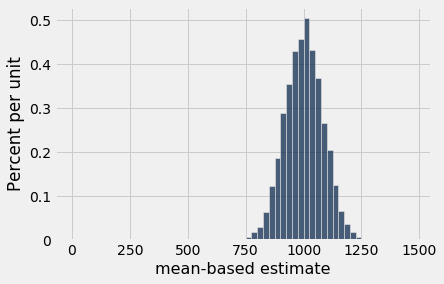

In [20]:
def bootstrap_estimates(original_table, sample_size, statistic, num_replications):
    estimates = []
    for i in np.arange(num_replications):
        sample = []
        for i in np.arange(sample_size):
            sample.append(np.random.choice(original_table.column(0)))
        estimates.append(statistic(sample))
    return estimates
        

# Don't change the code below this comment!
# This should generate an empirical histogram of twice-mean-based estimates
# of N from samples of size 50 if N is 1000.  This should be a bell-shaped
# curve centered at 1000 with most of its mass in [800, 1200].  To verify your
# answer, make sure that's what you see!
example_estimates = bootstrap_estimates(
    Table().with_column("serial number", np.arange(1, 1000+1)),
    50,
    mean_based_estimator,
    10000)
Table().with_column("mean-based estimate", example_estimates).hist(bins=np.arange(0, 1500, 25))

In [21]:
ok.grade("q2_3");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



Now we can go back to the sample we actually observed (the table `observations`) and estimate how much our mean-based estimate of `N` would have varied from sample to sample.

#### Question 2.4
Using the bootstrap and the sample `observations`, simulate the approximate distribution of *mean-based estimates* of `N`.  Use 10,000 replications and save the estimates in an array called `bootstrap_mean_based_estimates`.  

We have provided code that plots a histogram, allowing you to visualize the simulated estimates.

<!--
BEGIN QUESTION
name: q2_4
-->

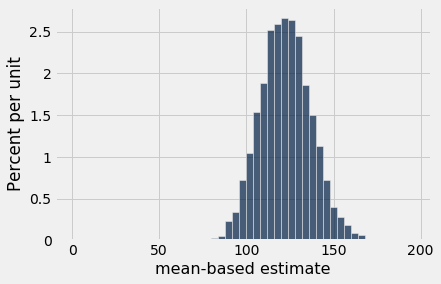

In [25]:
bootstrap_mean_based_estimates = bootstrap_estimates(observations, observations.num_rows, mean_based_estimator, 10000)

# Don't change the code below! This plots bootstrap_mean_based_estimates.
Table().with_column("mean-based estimate", bootstrap_mean_based_estimates).hist(bins=np.arange(0, 200, 4)) 

In [26]:
ok.grade("q2_4");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 2.5
Using the bootstrap and the sample `observations`, simulate the approximate distribution of *max estimates* of `N`.  Use 10,000 replications and save the estimates in an array called `bootstrap_max_estimates`.

We have provided code that plots a histogram, allowing you to visualize the simulated estimates.

<!--
BEGIN QUESTION
name: q2_5
-->

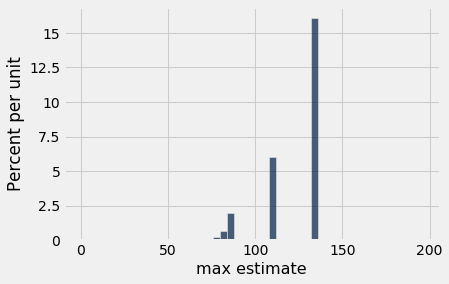

In [30]:
bootstrap_max_estimates = bootstrap_estimates(observations, observations.num_rows, max, 10000)

# Don't change the code below! This plots bootstrap_max_estimates.
Table().with_column("max estimate", bootstrap_max_estimates).hist(bins=np.arange(0, 200, 4)) 

In [31]:
ok.grade("q2_5");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 2.6
`N` was actually 150! Compare the histograms of estimates you generated in 2.4 and 2.5 and answer the following questions:

1. How does the distribution of values for the mean-based estimates differ from the max estimates? Do both distributions contain the true max value?
2. Which estimator is more dependent on the original random sample? Why so?

<!--
BEGIN QUESTION
name: q2_6
-->

1. The first distribution is more of a normal curve while the second is not. Only the first distribution contains the true max value. 
2. The estimator more dependent on the original random sample is the second one because its max depends on the max of the original random sample. 

## 3. Computing intervals

#### Question 3.1
Compute an interval that covers the middle 95% of the mean-based bootstrap estimates.  Assign your values to `left_end_1` and `right_end_1`. 

*Hint:* Use the `percentile` function! Read up on its documentation [here](http://data8.org/sp19/python-reference.html).

Verify that your interval looks like it covers 95% of the area in the histogram. The red dot on the histogram is the value of the parameter (150).

<!--
BEGIN QUESTION
name: q3_1
-->

Middle 95% of bootstrap estimates: [95.411765, 152.235294]


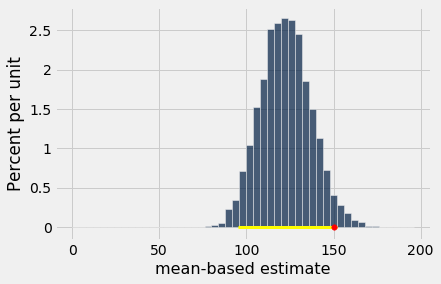

In [35]:
left_end_1 = percentile(2.5, bootstrap_mean_based_estimates)
right_end_1 = percentile(97.5, bootstrap_mean_based_estimates)
print("Middle 95% of bootstrap estimates: [{:f}, {:f}]".format(left_end_1, right_end_1))

# Don't change the code below! It draws your interval and N on the histogram of mean-based estimates.
Table().with_column("mean-based estimate", bootstrap_mean_based_estimates).hist(bins=np.arange(0, 200, 4)) 
plt.plot(make_array(left_end_1, right_end_1), make_array(0, 0), color='yellow', lw=3, zorder=1)
plt.scatter(150, 0, color='red', s=30, zorder=2);

In [36]:
ok.grade("q3_1");

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed



#### Question 3.2
Write code that simulates the sampling and bootstrapping process again, as follows:

1. Generate a new set of random observations the RAF might have seen by sampling from the `population` table we have created for you below. Use the sample size `num_observations`.
2. Compute an estimate of `N` from these new observations, using `mean_based_estimator`.
3. Using only the new observations, compute 10,000 bootstrap estimates of `N`.
4. Plot these bootstrap estimates and compute an interval covering the middle 95%.

<!--
BEGIN QUESTION
name: q3_2
-->

New mean-based estimate: 177.100000
Middle 95% of bootstrap estimates: [142.600000, 210.600000]


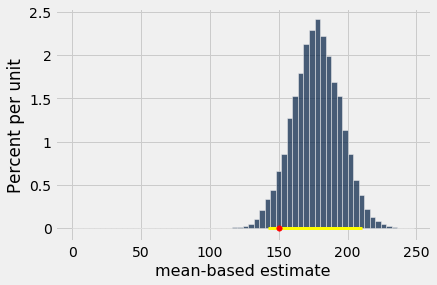

In [40]:
population = Table().with_column("serial number", np.arange(1, 150+1))

new_observations = Table().with_columns('serial number', np.random.choice(population.column(0), 20, replace = False))
new_mean_based_estimate = mean_based_estimator(new_observations.column(0))
new_bootstrap_estimates = bootstrap_estimates(new_observations, 20, mean_based_estimator, 10000)
Table().with_column("mean-based estimate", new_bootstrap_estimates).hist(bins=np.arange(0, 252, 4))
new_left_end = percentile(2.5, new_bootstrap_estimates)
new_right_end = percentile(97.5, new_bootstrap_estimates)

# Don't change code below this line!
print("New mean-based estimate: {:f}".format(new_mean_based_estimate))
print("Middle 95% of bootstrap estimates: [{:f}, {:f}]".format(new_left_end, new_right_end))

plt.plot(make_array(new_left_end, new_right_end), make_array(0, 0), color='yellow', lw=3, zorder=1)
plt.scatter(150, 0, color='red', s=30, zorder=2);

#### Question 3.3
Does the interval covering the middle 95% of the new bootstrap estimates include `N`?  If you ran that cell 100 times and generated 100 intervals, how many of those intervals would you expect to include `N`?

<!--
BEGIN QUESTION
name: q3_3
-->

Yes, and I would expect it to include N around 95 times. 

Congratulations, you're done with lab 7!  Be sure to 
- **run all the tests** (the next cell has a shortcut for that), 
- **Save and Checkpoint** from the `File` menu,
- **run the last cell to submit your work**,
- and ask one of the staff members to check you off.

In [43]:
# For your convenience, you can run this cell to run all the tests at once!
import os
print("Running all tests...")
_ = [ok.grade(q[:-3]) for q in os.listdir("tests") if q.startswith('q') and len(q) <= 10]
print("Finished running all tests.")

Running all tests...
~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 2
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running tests

---------------------------------------------------------------------
Test summary
    Passed: 1
    Failed: 0
[ooooooooook] 100.0% passed

~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
Running t

In [44]:
_ = ok.submit()

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Saving notebook... Saved 'lab07.ipynb'.
Submit... 100% complete
Submission successful for user: mingxiuhui@berkeley.edu
URL: https://okpy.org/cal/data8/sp19/lab07/submissions/0YEnAG

